In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
# ignores FutureWarnings. Helps in readbility.
# Since we are using a conda envrionment with defined package versions we are not concerned with changes in a package's future releases.


In [3]:
datadir = "data"
savedir = "plots"

if not os.path.exists(savedir):
    os.mkdir(savedir)

In [4]:
# paths to results
methods = ["MuSiC", "CibersortX", "Scaden", "TAPE-O", "TAPE-A", "Linear MLPs", "BayesPrism", "BayesPrism-M", "DISSECT"]
results = [os.path.join(datadir, f"{method.replace(' ', '_')}.csv") for method in methods]
results_dict = dict(zip(methods, results))

In [5]:
# read results
df_results_dict = {}

df_meta = pd.read_table(os.path.join(datadir, "metadata.txt"), index_col=0) # read metadata
for method in results_dict.keys():
    df = pd.read_table(results_dict[method], index_col=0)
    df_results_dict[method] = df
    common = list(set(df_meta["projid.x"].tolist())&set(df_results_dict[method].index.tolist()))
    
    df_results_dict[method] = df_results_dict[method].loc[common,:]
    df_meta.index = df_meta["projid.x"].tolist()
    df_meta = df_meta.loc[common,:]

    df_results_dict[method]["brc"] = df_meta["braaksc"].copy()

In [6]:
celltype_ylims = {"Astrocyte": [0,0.5],
                 "Endothelial": [0,0.20],
                 "Excitatory": [0,0.6],
                 "Inhibitory": [0,0.5],
                 "Microglia": [0,0.2],
                 "OPC": [0,0.1],
                 "Neurons": [0,1],
                 "Oligodendrocyte": [0,0.36],
                 "Excitatory \n(out of neurons)": [0,1],
                 "Inhibitory \n(out of neurons)": [0,1]}

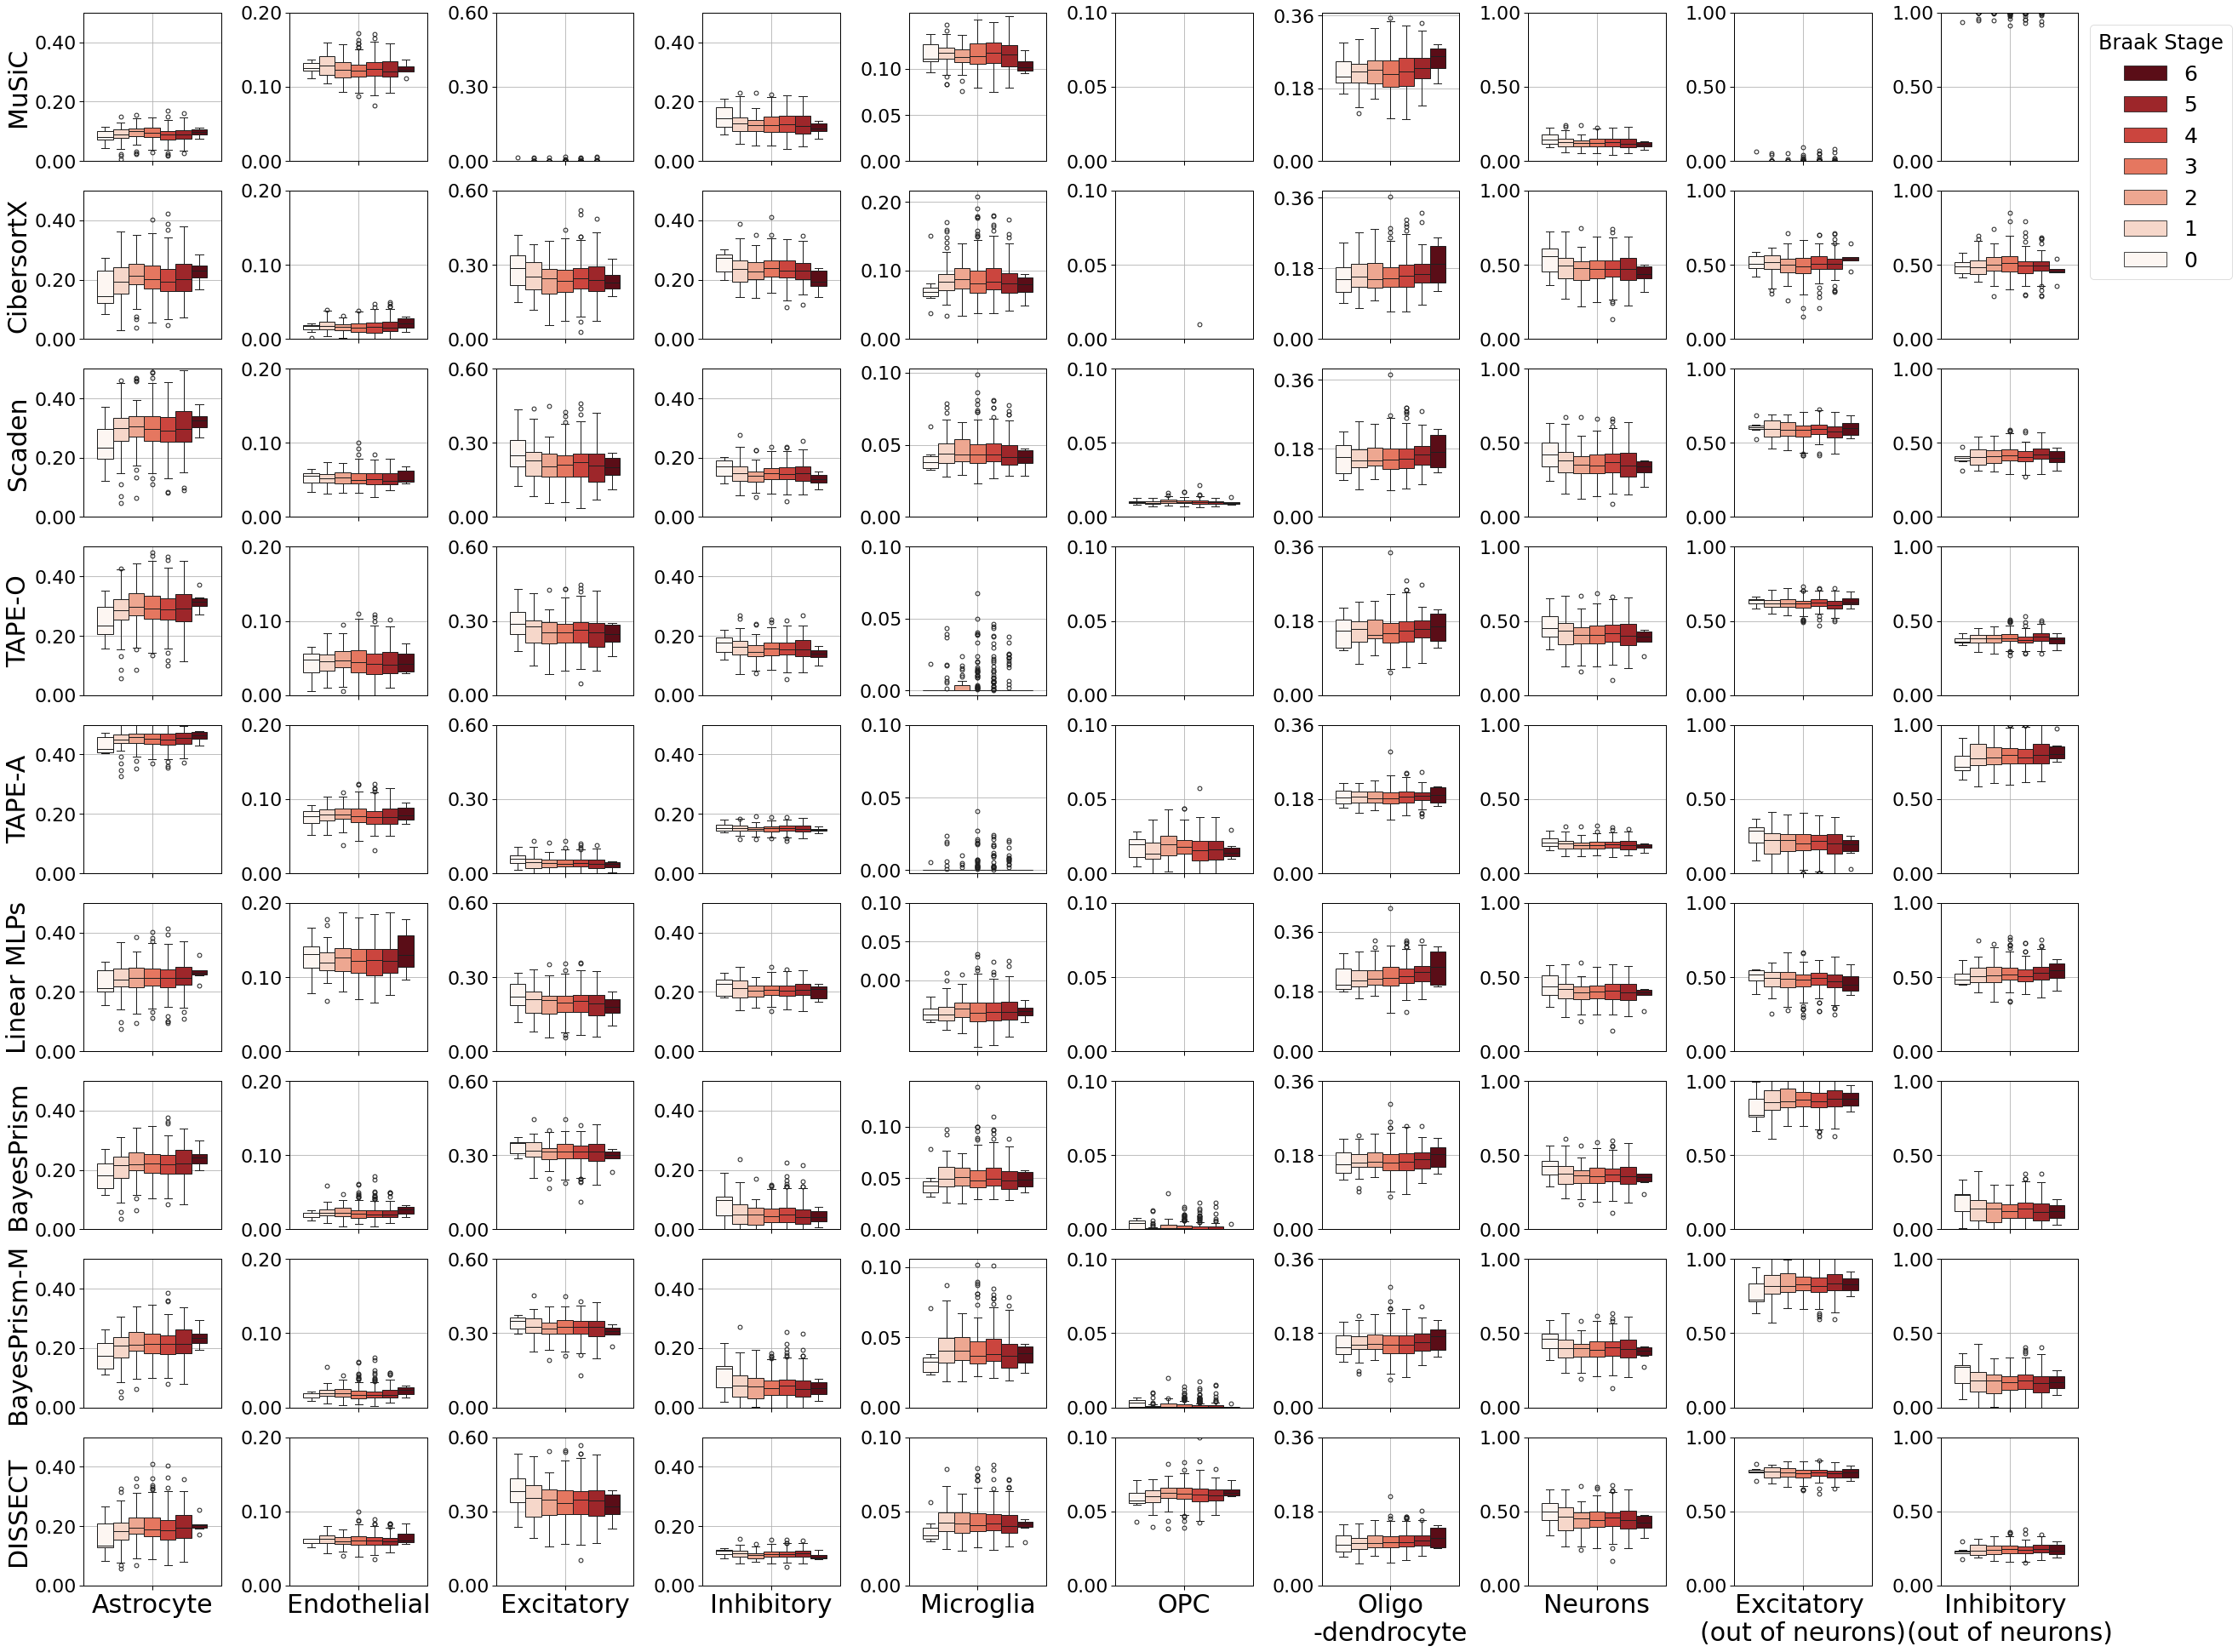

In [10]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(42, 34))

j=0
for method in df_results_dict.keys():
    j +=1
    temp = df_results_dict[method]
    temp = temp[sorted(temp.columns)]
    temp.loc[:,"Neurons"] = np.array(temp["Excitatory"]) + np.array(temp["Inhibitory"])

    if "VLMC" in temp.columns:
        ## VLMC, Pericyte make up unknown
        # For deep neural network based methods (Scaden, TAPE, Linear MLPs and DISSECT),
        # during training, VLMC and Pericytes were grouped to make unknown cell type. 
        temp.loc[:,"unknown"] = np.array(temp["VLMC"]) + np.array(temp["Pericyte"])
    # Remove unknown component
    temp = temp[[col for col in temp.columns if col not in ["VLMC", "Pericyte"]]]
    temp["Excitatory \n(out of neurons)"] = temp["Excitatory"]/temp["Neurons"]
    temp["Inhibitory \n(out of neurons)"] = temp["Inhibitory"]/temp["Neurons"]

    sns.set_context("paper", font_scale=2.5)
    temp_melted = temp.melt(id_vars=["brc"], var_name="Celltype", value_name="Fraction")

    # show known cell types
    celltypes = [celltype for celltype in temp_melted.Celltype.unique() if celltype!="unknown"]

    from matplotlib.ticker import FormatStrFormatter

    for i in range(len(celltypes)):

        plt.subplot(len(list(df_results_dict.keys())),len(celltypes),(j-1)*len(celltypes)+(i+1))
        g=sns.boxplot(data=temp_melted[temp_melted.Celltype==celltypes[i]], x="Celltype", y="Fraction", hue="brc",
                     palette="Reds")
        g.set_facecolor('white')
        if i==0:
            g.set_ylabel(method, size=30)

        else:
            g.set_ylabel("")
        g.set_xlabel("")

        if i==len(celltypes)-1 and j==1:
            handles, labels = g.get_legend_handles_labels()

            g.legend(reversed(handles), reversed(labels), title="Braak Stage",
                         loc='upper center', bbox_to_anchor=(1.6,0.99), facecolor="white", fontsize=25)
        else:
            g.legend([],[], frameon=False)
        if j==len(list(df_results_dict.keys())):
            name=celltypes[i]
            if name=="Oligodendrocyte":
                name="Oligo\n-dendrocyte"

            g.set_xticklabels([name], size=30)
        else:
            g.set_xticklabels([], size=None)
        g.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        if celltypes[i]=="Excitatory":
            plt.yticks(np.arange(celltype_ylims[celltypes[i]][0], celltype_ylims[celltypes[i]][1]+.1, 0.3))
        if celltypes[i]=="Microglia" and method!="CibersortX":
            plt.yticks(np.arange(0, 0.1+.02, 0.05))
        if celltypes[i]=="Microglia" and method=="CibersortX":
            plt.yticks(np.arange(celltype_ylims[celltypes[i]][0], 0.22, 0.1))
        if celltypes[i]=="Oligodendrocyte":
            plt.yticks(np.arange(celltype_ylims[celltypes[i]][0], celltype_ylims[celltypes[i]][1]+.05, 0.18))

        else:
            if celltypes[i]!="Microglia":
                g.set_ylim(celltype_ylims[celltypes[i]][0], celltype_ylims[celltypes[i]][1],)
        plt.grid()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.2)
#plt.tight_layout()
plt.savefig("brain_rosmap_brc.png")